In [1]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.masked import masked
from toolbar.significance_test import r_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *


def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map


time = [1961, 2022]
heating = xr.open_dataset(r'E:\data\JRA55\JRA55_monthly_heating_1961_2023.nc').sel(time=slice(str(time[0]) + '-01', str(time[1]) + '-12'))
heating = heating.sel(time=heating['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'plev', 'lat', 'lon')
K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [2]:
def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    if yticks1 is not None: ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    if xticks1 is not None: ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=8, colors='black')


reg_map, corr_map = np.zeros(
    (3, 5, len(heating.plev), len(heating.lat), len(heating.lon))), np.zeros(
    (3, 5, len(heating.plev), len(heating.lat), len(heating.lon)))

for i in tq.trange(len(K_type['type'])):
    K_series = K_type.sel(type=i + 1)['K'].data
    if i == 1: K_series = K_series - np.polyval(np.polyfit(range(len(K_series)), K_series, 1), range(len(K_series)))
    K_series = (K_series - np.mean(K_series)) / np.std(K_series)
    reg_map[i, 0], corr_map[i, 0] = regress(K_series, heating['var242'].data)
    reg_map[i, 1], corr_map[i, 1] = regress(K_series, heating['var241'].data)
    reg_map[i, 2], corr_map[i, 2] = regress(K_series, heating['var251'].data)
    reg_map[i, 3], corr_map[i, 3] = regress(K_series, heating['var250'].data)
    reg_map[i, 4], corr_map[i, 4] = regress(K_series, heating['var246'].data)
reg_map = xr.Dataset({'cnvhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 0]),
                      'lrghr': (['type', 'level', 'lat', 'lon'], reg_map[:, 1]),
                      'lwhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 2]),
                      'swhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 3]),
                      'vdfhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 4])},
                     coords={'type': K_type['type'], 'level': heating.plev.data, 'lat': heating.lat, 'lon': heating.lon})
corr_map = xr.Dataset({'cnvhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 0]),
                       'lrghr': (['type', 'level', 'lat', 'lon'], corr_map[:, 1]),
                       'lwhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 2]),
                       'swhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 3]),
                       'vdfhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 4])},
                      coords={'type': K_type['type'], 'level': heating.plev.data, 'lat': heating.lat, 'lon': heating.lon})


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\86136\AppData\Local\Temp\ipykernel_16568\1550256764.py:44: RuntimeWarning: invalid value encountered in divide
  correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
C:\Users\86136\AppData\Local\Temp\ipykernel_16568\2464443462.py:112: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax_bar.grid(False, linestyle='--', zorder=0, axis='y')
100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
C:\Users\86136\AppData\Local\Temp\ipykernel_16568\2464443462.py:112: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax_bar.grid(False, linestyle='--', zorder=0, axis='y')
100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
C:\Users\86136\AppData\Local\Temp\ipykernel_16568\2464443462.py:112: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax_bar.grid(False, linestyle='--', zorder=0, axis='y')
100%|██████████| 3/3 [00:38<00:00, 12.71s/it]


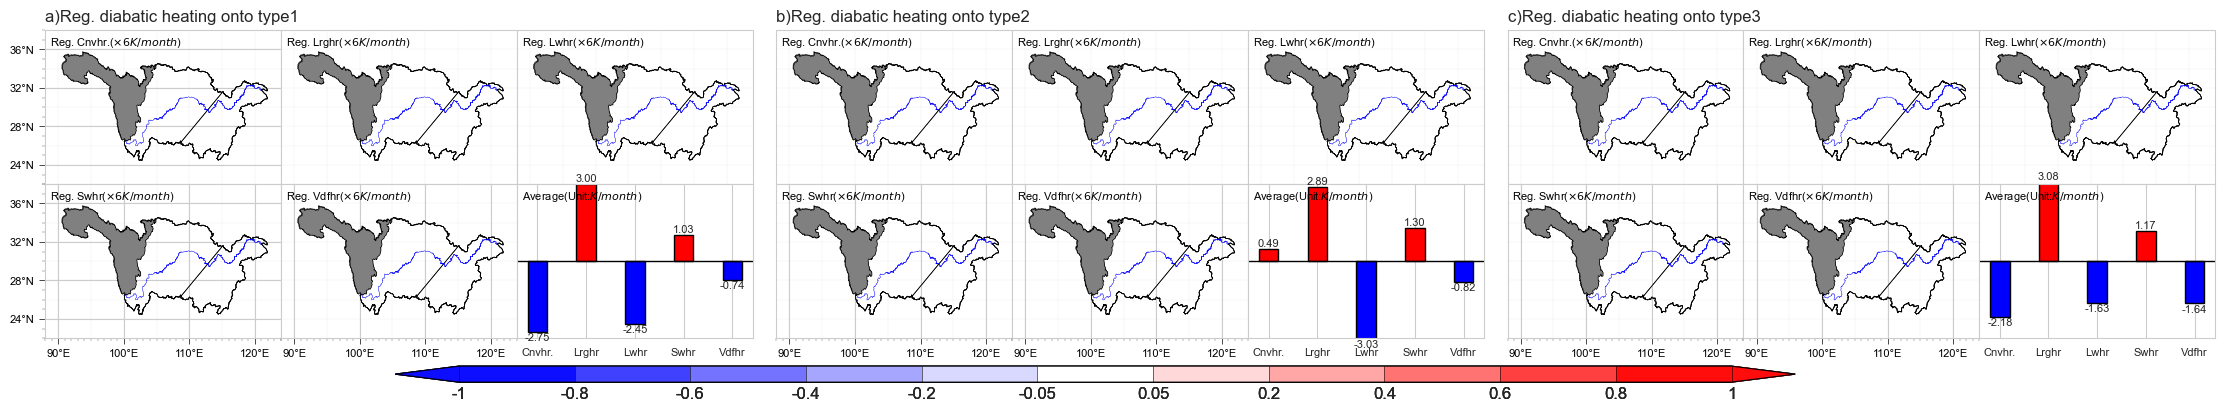

In [4]:
p_th = r_test(62, 0.05)  # 62为样本量，0.1为显著性水平
var = ['cnvhr', 'lrghr', 'lwhr', 'swhr', 'vdfhr']
var_out = [r'Cnvhr.', r'Lrghr', r'Lwhr', r'Swhr', r'Vdfhr']

# 绘图
fig = plt.figure(figsize=(28, 4))
fig.subplots_adjust(hspace=0.2)
extent_CN = [88, 124, 22, 38]  # Increase vertical spacing between subplots
gs = gridspec.GridSpec(2, 11, width_ratios=[1, 1, 1, .1, 1, 1, 1, .1, 1, 1, 1], height_ratios=[1, 1] ,wspace=0, hspace=0)
pic_loc =[[0, 1, 2, 11, 12, 13], [4, 5, 6, 15, 16, 17], [8, 9, 10, 19, 20, 21]]
xticks1 = np.arange(extent_CN[0], extent_CN[1] + 1, 10)
yticks1 = np.arange(extent_CN[2], extent_CN[3] + 1, 10)

for KType in tq.trange(1, 4):
    if KType == 3:
        reg_map_ = masked(reg_map, r"D:\Code\work\Meteorological\p2\map\WYTR\长江_tp.shp")
    elif KType == 1:
        reg_map_ = masked(reg_map, r"D:\Code\work\Meteorological\p2\map\EYTR\长江_tp.shp")
    elif KType == 2:
        reg_map_ = masked(reg_map, r'D:\PyFile\map\self\长江_TP\长江_tp.shp')
    interp_lon = np.linspace(88, 124, 1000)
    interp_lat = np.linspace(22, 38, 500)
    reg_ = masked(reg_map.interp(lon=interp_lon, lat=interp_lat), r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").sel(type=KType,level=np.array([1000])*100).mean(dim='level')
    reg = reg_map_.sel(type=KType, level=np.array([1000])*100).mean(dim='level')
    corr = corr_map.sel(type=KType, level=np.array([1000])*100)
    for ipic in tq.trange(5):
        ax1 = fig.add_subplot(gs[pic_loc[KType-1][ipic]], projection=ccrs.PlateCarree(central_longitude=180 - 70))
        if ipic==0:ax1.set_title(f"{chr(ord('a') + KType - 1)})Reg. diabatic heating onto type{KType}", fontsize=12, loc='left')
        ax1.set_extent(extent_CN, crs=ccrs.PlateCarree(central_longitude=0))
        ax1.set_aspect('auto')
        ####
        num_times = [6, 6, 6, 6, 6]
        lev_cnvhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[0]
        lev_lrghr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[1]
        lev_lwhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[2]
        lev_swhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[3]
        lev_vdfhr = np.array([-1., -.8, -.6, -.4, -.2, -.05,.05,.2,.4,.6,.8, 1.]) * num_times[4]
        lev = np.array([lev_cnvhr, lev_lrghr, lev_lwhr, lev_swhr, lev_vdfhr])
        #lev= 10
        contf = ax1.contourf(reg_['lon'], reg_['lat'], reg_[var[ipic]] * 31,
                             cmap=cmaps.GMT_polar[0:9] + cmaps.CBR_wet[0] + cmaps.GMT_polar[11:],
                             levels=lev[ipic], extend='both', transform=ccrs.PlateCarree(central_longitude=180))
        ####
        ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                           facecolor='none', edgecolor='black', linewidth=.5)
        ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(),
                           ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
        ax1.add_geometries(Reader(r'D:\Code\work\Meteorological\p2\map\EYTR\长江_tp.shp').geometries(),
                          ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black', linewidth=.5)
        ax1.add_geometries(Reader(r'D:\Code\work\Meteorological\p2\map\WYTR\长江_tp.shp').geometries(),
                          ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black', linewidth=.5)
        ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(),
                           facecolor='none', edgecolor='blue', linewidth=0.2)
        ax1.add_geometries(Reader(
            r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(),
                           ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5, zorder=11)
        ax1.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)
        if ipic==3 and KType==1: latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(10), MultipleLocator(1), MultipleLocator(4), MultipleLocator(1))
        elif ipic==3: latlon_fmt(ax1, xticks1, None, MultipleLocator(10), MultipleLocator(1), MultipleLocator(4), MultipleLocator(1))
        elif ipic==4 or ipic==5: latlon_fmt(ax1, xticks1, None, MultipleLocator(10), MultipleLocator(1), MultipleLocator(4), MultipleLocator(1))
        elif ipic==0 and KType==1: latlon_fmt(ax1, None, yticks1, MultipleLocator(10), MultipleLocator(1), MultipleLocator(4), MultipleLocator(1))

                # 在右上角添加标注 (坐标范围是轴坐标0-1)
        if ipic==0:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
        elif ipic==1:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
        elif ipic==2:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
        elif ipic==3:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
        elif ipic==4:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
        elif ipic==5:
            ax1.text(0.02, 0.90, fr'Reg. {var_out[ipic]}($\times{num_times[ipic]}K/month$)',
                 transform=ax1.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))

        # 边框显示为黑色
        ax1.spines['top'].set_color('black')
        ax1.spines['right'].set_color('black')
        ax1.spines['bottom'].set_color('black')
        ax1.spines['left'].set_color('black')
        if ipic == 0: ax_1 = ax1
        elif ipic == 1: ax_2 = ax1
        elif ipic == 2: ax_3 = ax1
        elif ipic == 3: ax_4 = ax1
        elif ipic == 4: ax_5 = ax1
        elif ipic == 5: ax_6 = ax1

    ax_bar = fig.add_subplot(gs[pic_loc[KType-1][5]])
    ax_bar.set_aspect('auto')
    cnvhr = np.nanmean(reg['cnvhr'])* 31
    lrghr = np.nanmean(reg['lrghr'])* 31
    lwhr = np.nanmean(reg['lwhr'])* 31
    swhr = np.nanmean(reg['swhr'])* 31
    vdfhr = np.nanmean(reg['vdfhr'])* 31

    # 在计算完三个变量之后添加以下代码

    # 准备绘图数据
    variables = ['cnvhr', 'lrghr', 'lwhr', 'swhr', 'vdfhr']
    values = [cnvhr, lrghr, lwhr, swhr, vdfhr]
    colors = ['red' if val > 0 else 'blue' for val in values]
    # 添加标题和网格
    ax_bar.grid(False, linestyle='--', zorder=0, axis='y')
    ax_bar.text(0.02, 0.90, fr'Average(Unit:$K/month$)',
                 transform=ax_bar.transAxes, fontsize=8, color='black', bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))
    bars = ax_bar.bar(range(5), values, width=0.4, color=colors, edgecolor='black', zorder=2)
    # 设置坐标轴标签
    ax_bar.set_xticks(range(5))
    ax_bar.set_xticklabels([i for i in var_out], fontsize=8)
    # 设置y轴范围
    ymax = 3
    ax_bar.set_ylim(-ymax, ymax)
    # 不显示y轴刻度
    ax_bar.set_yticks([])
    # 在柱状图上下添加数据标签
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax_bar.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        elif height < 0:
            ax_bar.text(bar.get_x() + bar.get_width() / 2, height-0.04, f'{height:.2f}', ha='center', va='top', fontsize=8)
    # 添加零线
    ax_bar.axhline(0, color='black', lw=1)

    ax1_colorbar = fig.add_axes([0.25, 0.00, 0.5, 0.04])
    cb1 = plt.colorbar(contf, cax=ax1_colorbar, orientation='horizontal', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black')  # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(lev[ipic])
    cb1.set_ticklabels(['-1', '-0.8', '-0.6', '-0.4', '-0.2', '-0.05', '0.05', '0.2', '0.4', '0.6', '0.8', '1'])
    cb1.ax.tick_params(length=0, labelsize=12)  # length为刻度线的长度
plt.savefig(f'D:/PyFile/p2/pic/加热率收支.png', dpi=600, bbox_inches='tight')
plt.show()

# cnvhr = np.nanmean(reg['cnvhr'])* 31
# lrghr = np.nanmean(reg['lrghr'])* 31
# lwhr = np.nanmean(reg['lwhr'])* 31
# swhr = np.nanmean(reg['swhr'])* 31
# vdfhr = np.nanmean(reg['vdfhr'])* 31
#
# # 在计算完三个变量之后添加以下代码
#
# # 准备绘图数据
# variables = ['cnvhr', 'lrghr', 'lwhr', 'swhr', 'vdfhr']
# values = [cnvhr, lrghr, lwhr, swhr, vdfhr]
# colors = ['red' if val > 0 else 'blue' for val in values]
#
# # 创建柱状图
# fig, ax = plt.subplots(figsize=(16, 9))
# # 添加标题和网格
# ax.set_title('a)Heating rate', pad=20, fontsize=14, fontweight='bold', loc='left')
# ax.grid(True, linestyle='--', zorder=0, axis='y')
#
# bars = ax.bar(range(5), values, width=0.4, color=colors, edgecolor='black', zorder=2)
#
# # 设置坐标轴标签
# ax.set_xticks(range(5))
# ax.set_xticklabels([i for i in var_out], fontsize=12)
#
# # 设置y轴范围
# ymax = 3
# ax.set_ylim(-ymax, ymax)
#
# # 添加零线
# ax.axhline(0, color='black', lw=1)
#
# plt.tight_layout()
# plt.savefig(f'D:/PyFile/p2/pic/辐射收支type{KType}_bar.pdf', dpi=600, bbox_inches='tight')
# plt.show()